In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pymysql
from scipy.sparse import load_npz, csr_matrix, save_npz
import matplotlib.pyplot as plt
import numpy as np
from implicit.evaluation import train_test_split

import warnings
# suppress just that particular UserWarning from pandas.read_sql
warnings.filterwarnings(
    "ignore",
    message="pandas only supports SQLAlchemy connectable",
    category=UserWarning
)


import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    python_path = os.path.join(module_path, 'python')
    sys.path.append(python_path)
    
from dusa_function_lib import (
    build_directory_city_name,
    build_db_name,
)

from boost_fairness import (
    strategy_add_global,
    strategy_add_comments_by_group,
    strategy_drop_comments_by_group,
    strategy_put_one_comment_by_group,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


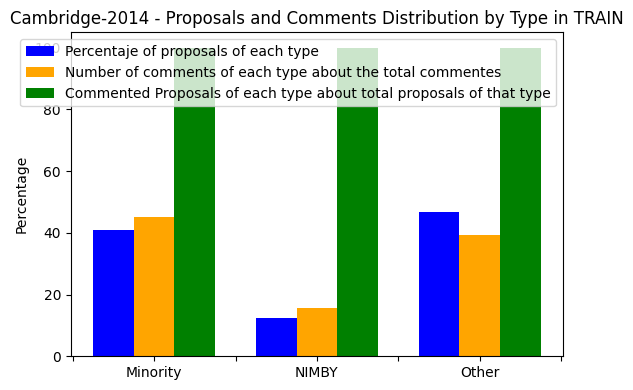

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


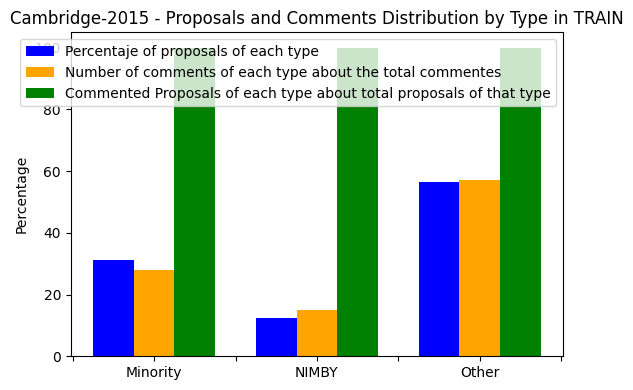

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


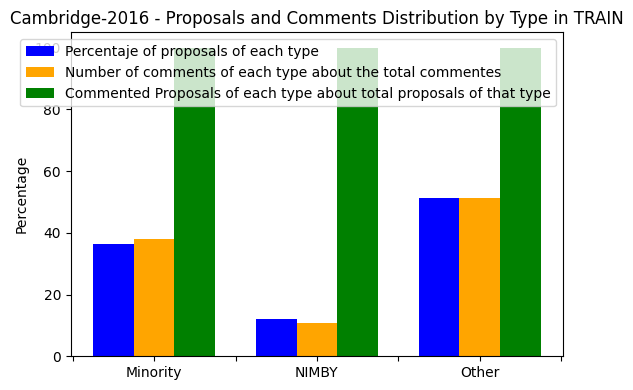

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


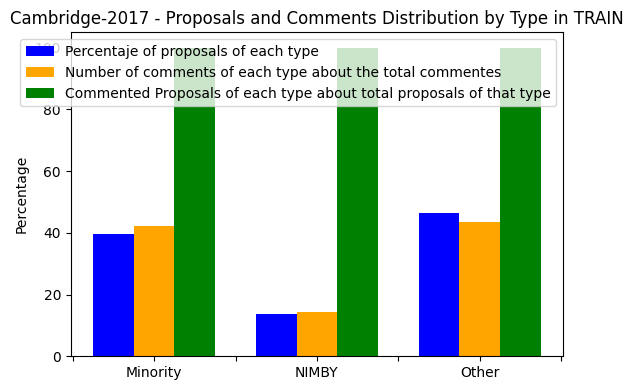

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


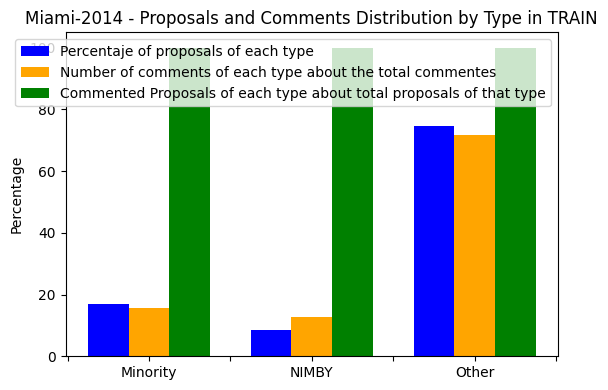

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


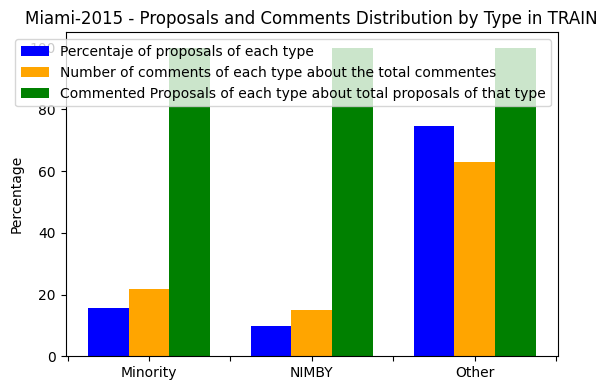

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


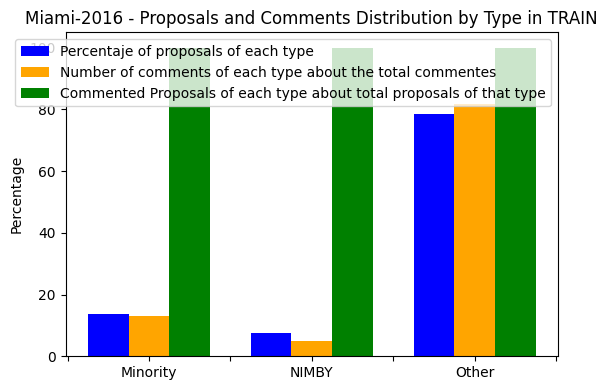

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


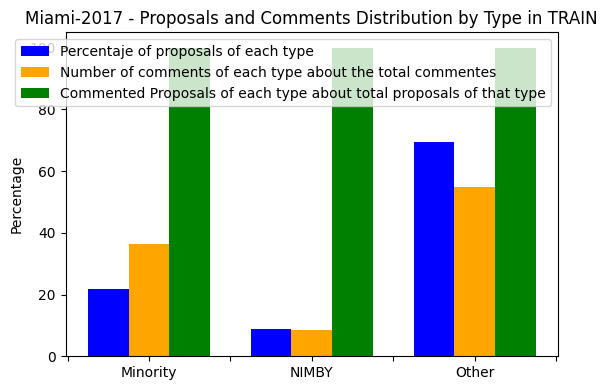

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


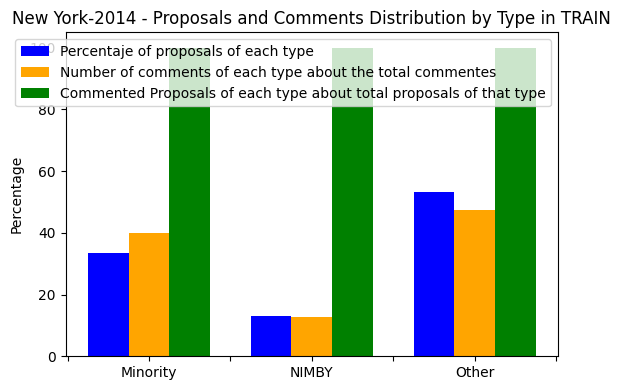

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


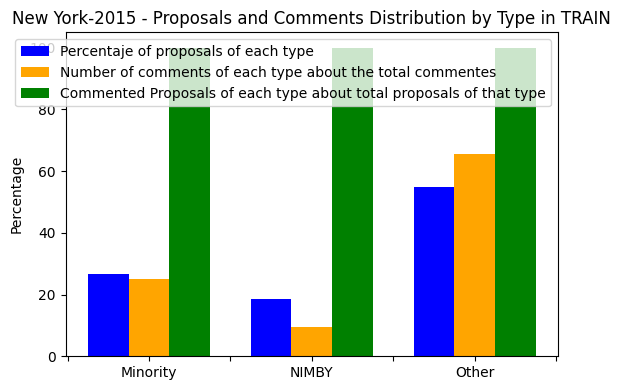

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


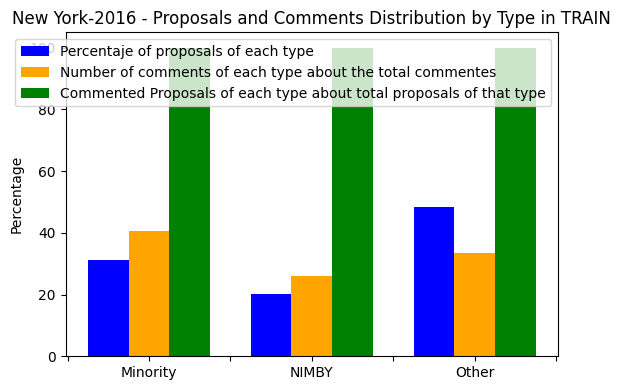

C:\Users\molin\AppData\Local\Temp\ipykernel_4960\743877247.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])


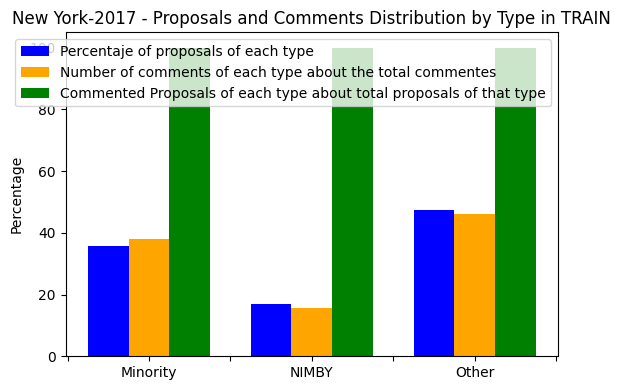

In [9]:
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']

connection = pymysql.connect(
    host='localhost',
    user='eduardomv',
    password='*****',
    database='participatory_budgeting'
)

for city in cities:
    city_dir = build_directory_city_name(city)
    for year in years:
        city_year_dir = f"{city_dir}/{year}"
        min_nim_df = pd.read_csv(f"../../../Code/Apache_Lucene_Index/data/results2/{city_year_dir}/cl_gpt.csv", sep='|')
        min_nim_df = min_nim_df[['id', 'type']]
        database_name = build_db_name(city, year)
        query = f"""
        SELECT itemId, COUNT(*) as num_comments
        FROM 
            ratings r
        WHERE
            dataset = '{database_name}'
        GROUP BY itemId
        ORDER BY itemId ASC
        """
        num_comments_df = pd.read_sql(query, connection)
        # print(f"There are {num_comments_df.shape[0]} rows in num_comments_df for {city}-{year}")
        df = num_comments_df.merge(
            min_nim_df,
            left_on='itemId',
            right_on='id',
            how='left'
        )
        df['type'] = df['type'].fillna('other')
        # print(df.info())
        df['num_comments'] = df['num_comments'].fillna(0)
        
        df['true_comment'] = df['num_comments'].apply(lambda x: 1 if x > 0 else 0)
        
        data_num_comm_matrix_dir = f"../../data/rm/{city_year_dir}/basic"
    
        num_comm_matrix_train= load_npz(f"{data_num_comm_matrix_dir}/num_comm_train.npz")
        # 1. % of proposals of each type
        total_proposals = num_comm_matrix_train.shape[1]
        perc_props = df['type'].value_counts() / total_proposals * 100
        
        # 2. % of number of comments in proposals of each type about total number of comments in all proposals
        total_comments = df['num_comments'].sum()
        perc_comments = df.groupby('type')['num_comments'].sum() / total_comments * 100
        
        # 3. % of commented proposals of each type about total proposals of that type
        total_props_type = df['type'].value_counts()
        perc_commented_props = df.groupby('type')['true_comment'].sum() / total_props_type * 100
        
        categories = ['minority', 'nimby', 'other']
        p1 = [perc_props.get(cat, 0) for cat in categories]
        p2 = [perc_comments.get(cat, 0) for cat in categories]
        p3 = [perc_commented_props.get(cat, 0) for cat in categories]
        
        x = np.arange(len(categories))  # the label locations
        width = 0.25
        
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(x - width, p1, width, label='Percentaje of proposals of each type', color='blue')
        ax.bar(x, p2, width, label='Number of comments of each type about the total commentes', color='orange')
        ax.bar(x + width, p3, width, label='Commented Proposals of each type about total proposals of that type', color='green')
        
        ax.set_ylabel('Percentage')
        ax.set_title(f"{city}-{year} - Proposals and Comments Distribution by Type in TRAIN")
        ax.set_xticklabels(['','','Minority','', 'NIMBY','', 'Other'])
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        
        

# Create Strategies

### Strategy 1: Add global noise
Randomly add noise to the train matrix with probability `p_add`. It sums 1 coment in those selected entries of the matrix.

This probability is set to 0.5.



### Strategy 2: Add comments.
Sums one comment per user and proposal with a certain probability for each group of proposals. The probability of adding comments are:
- p_minority = 0.05
- p_nimby = 0.15
- p_group = 0

### Strategy 3: Add comments if there are no comments.
Sums one comment per user and proposals only if there are no comments for that user in that proposal, with a certain probability for each group of proposals. The probability of adding comments are:
- p_minority = 0.05
- p_nimby = 0.15
- p_group = 0

This strategy should have similar results to the previous one.

### Strategy 4: Drop comments to 0 in proposals.
Randomly zeroes out a fraction of some gruops of proposals. The probability of dropping comments to 0 are:
- p_minority = 0
- p_nimby = 0
- p_group = 0.6

### Strategy 5: Hybrid drop and add comments.
We are going to combine strategy 3 and strategy 4.
Firstly, we are going to drop comments to 0 in a fraction of proposals with probability:
- p_minority = 0
- p_nimby = 0
- p_group = 0.25 

Then, we are going to add comments to the proposals that have no comments with probability:
- p_minority = 0.05
- p_nimby = 0.1 
- p_group = 0

In [ ]:
for city in cities:
    city_dir = build_directory_city_name(city)
    for year in years:
        print(f"Processing {city}-{year}")
        city_year_dir = f"{city_dir}/{year}"
        data_num_comm_matrix_dir = f"../../data/rm/{city_year_dir}"
        num_comm_matrix= load_npz(f"{data_num_comm_matrix_dir}/basic/num_comm_train.npz")
        item_mapping = pd.read_csv(
            f"{data_num_comm_matrix_dir}/basic/item_mapping.csv", sep='|'
        ) # [itemId, new_itemId]    new_itemId is the index of the item in the matrix
        user_mapping = pd.read_csv(
            f"{data_num_comm_matrix_dir}/basic/user_mapping.csv", sep='|'
        )
        min_nim_df = pd.read_csv(
            f"../../../Code/Apache_Lucene_Index/data/results2/{city_year_dir}/cl_gpt.csv", sep='|'
        )
        min_nim_df = min_nim_df[['id', 'type']]
        types_df = item_mapping.merge(
            min_nim_df,
            left_on='itemId',
            right_on='id',
            how='left'
        )
        types_df['type'] = types_df['type'].fillna('other')
        types_df.drop(columns=['id'], inplace=True) # we have itemId column already complete without NaN values
        
        
        # we sort by new_itemId to have the same order as the matrix and extract the types ordered by new_itemId
        types_df = types_df.sort_values(by='new_itemId')
        types_array = list(types_df['type'].values)
        
        ### STRATEGY 1 ###
        matrices = []
        strategies = ['add_global', 'add', 'add_in_zeros', 'drop', 'drop_add']
        # strategies = ['add_global']
        mat_str1 = strategy_add_global(num_comm_matrix, p_add=0.8)
        matrices.append(mat_str1)
        mat_str2 = strategy_add_comments_by_group(num_comm_matrix, types_array, p_add_minority=0.05, p_add_nimby=0.15, p_add_other=0) 
        matrices.append(mat_str2)
        mat_str3 = strategy_put_one_comment_by_group(num_comm_matrix, types_array, p_minority=0.05, p_nimby=0.15, p_other=0)
        matrices.append(mat_str3)
        mat_str4 = strategy_drop_comments_by_group(num_comm_matrix, types_array, p_drop_minority=0, p_drop_nimby=0, p_drop_other=0.6)
        matrices.append(mat_str4)
        mat_str5 = strategy_drop_comments_by_group(num_comm_matrix, types_array, p_drop_minority=0, p_drop_nimby=0, p_drop_other=0.25)
        mat_str5 = strategy_put_one_comment_by_group(mat_str5, types_array, p_minority=0.05, p_nimby=0.1, p_other=0)
        matrices.append(mat_str5)


        for matrix, name_strateg in zip(matrices, strategies):
            print(f"\t- Processing strategy {name_strateg}")
            mat_train = matrix.copy()
            mat_train = mat_train.astype(float)
            # mat_test = mat_test.astype(float)
            dirname = f"{data_num_comm_matrix_dir}/{name_strateg}"
            os.makedirs(dirname, exist_ok=True)
            # save_npz(f"{dirname}/num_comm_matrix.npz", matrix)
            save_npz(f"{dirname}/num_comm_train.npz", mat_train)
            # save_npz(f"{dirname}/num_comm_test.npz", mat_test)
            user_mapping.to_csv(f"{dirname}/user_mapping.csv", sep='|', index=False)
            item_mapping.to_csv(f"{dirname}/item_mapping.csv", sep='|', index=False)
        
        print(f"Finished processing {city}-{year}")
        
        

Processing Cambridge-2014
	- Processing strategy add_global
Finished processing Cambridge-2014
Processing Cambridge-2015
	- Processing strategy add_global
Finished processing Cambridge-2015
Processing Cambridge-2016
	- Processing strategy add_global
Finished processing Cambridge-2016
Processing Cambridge-2017
	- Processing strategy add_global
Finished processing Cambridge-2017
Processing Miami-2014
	- Processing strategy add_global
Finished processing Miami-2014
Processing Miami-2015
	- Processing strategy add_global
Finished processing Miami-2015
Processing Miami-2016
	- Processing strategy add_global
Finished processing Miami-2016
Processing Miami-2017
	- Processing strategy add_global
Finished processing Miami-2017
Processing New York-2014
	- Processing strategy add_global
Finished processing New York-2014
Processing New York-2015
	- Processing strategy add_global
Finished processing New York-2015
Processing New York-2016
	- Processing strategy add_global
Finished processing New Yor

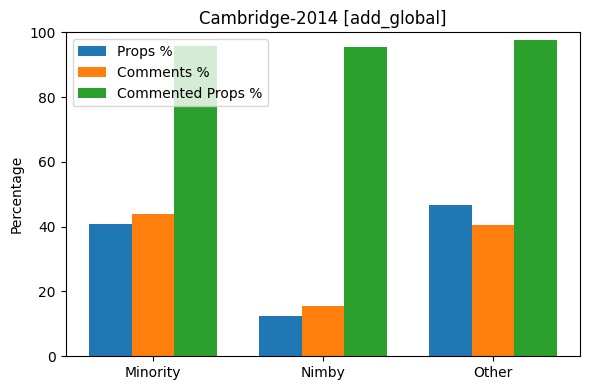

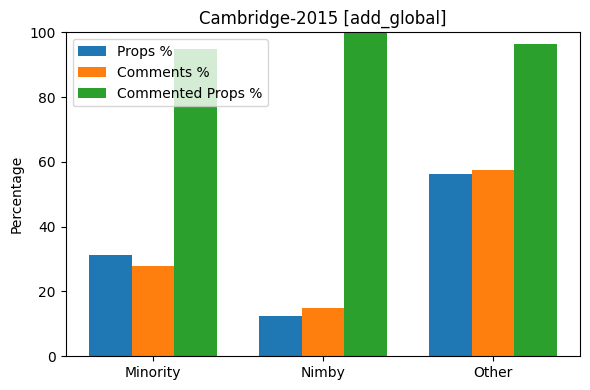

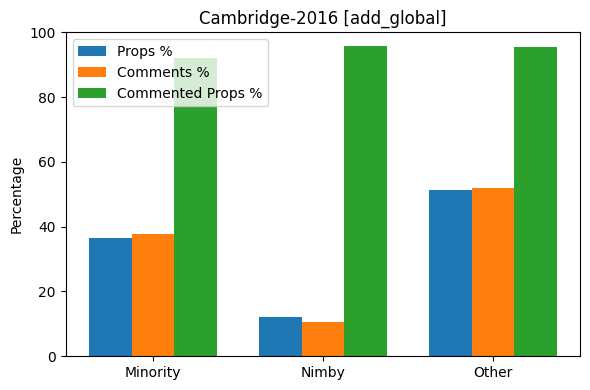

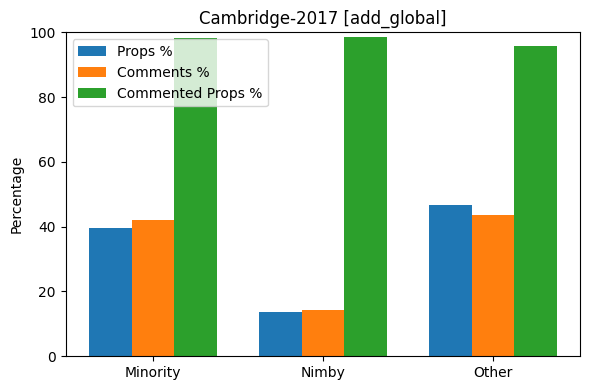

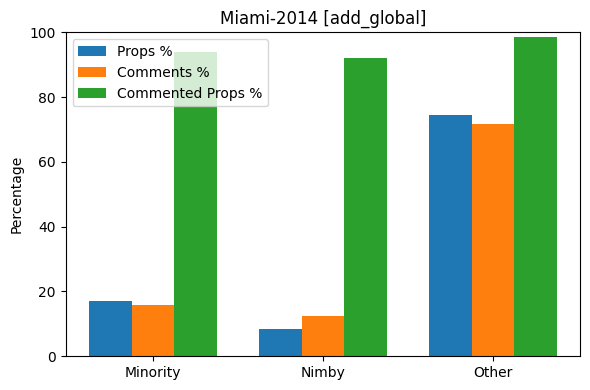

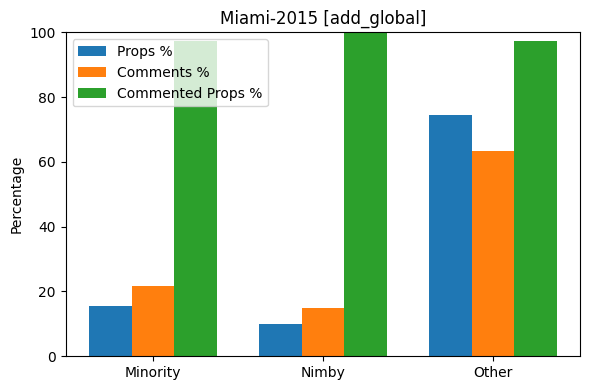

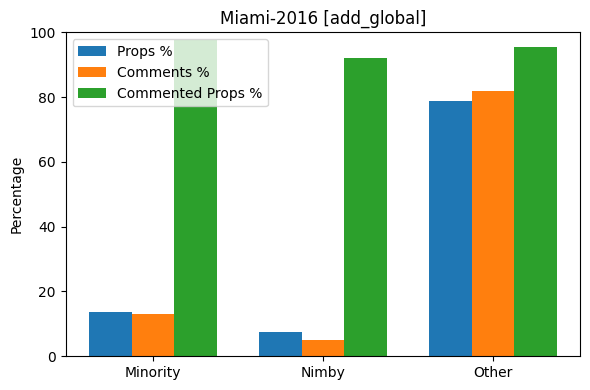

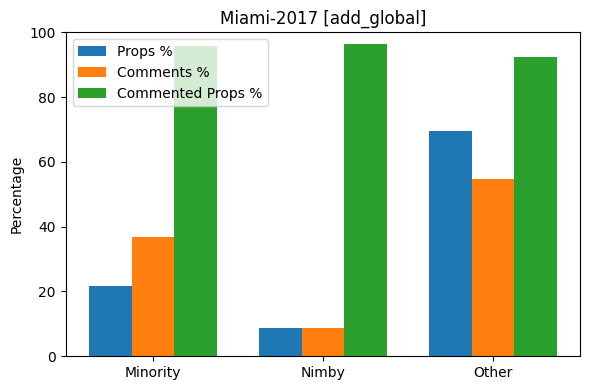

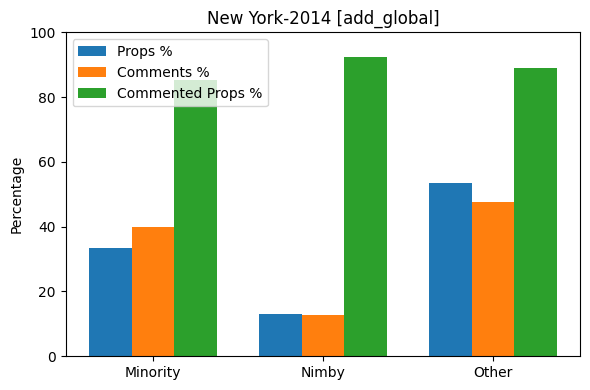

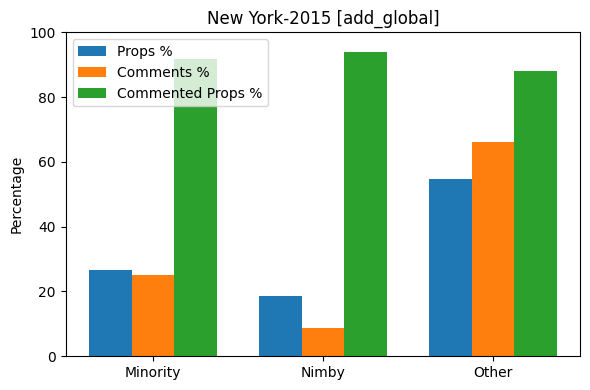

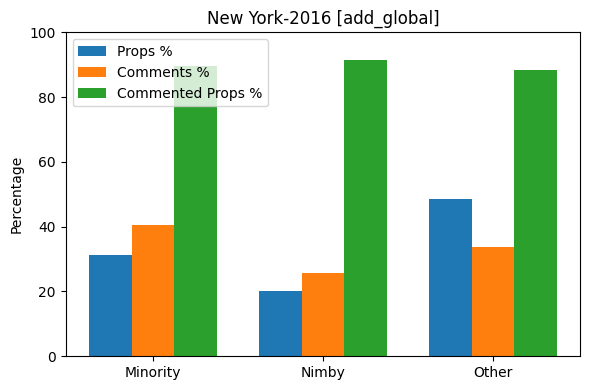

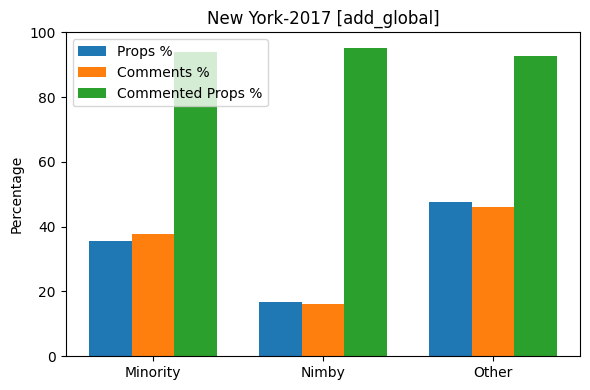

In [15]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

cities = ['Cambridge', 'Miami', 'New York']
years  = ['2014', '2015', '2016', '2017']
# strategies = ['basic', 'add_global', 'add', 'add_in_zeros', 'drop', 'drop_add']
strategies = ['add_global']
for city in cities:
    city_dir = build_directory_city_name(city)
    for year in years:
        city_year_dir = f"{city_dir}/{year}"
        # 1) Cargo el mapping de ítems y tipos
        item_mapping = pd.read_csv(
            f"../../data/rm/{city_year_dir}/basic/item_mapping.csv", sep='|'
        )  # columnas: [itemId, new_itemId]
        min_nim_df = pd.read_csv(
            f"../../../Code/Apache_Lucene_Index/data/results2/{city_year_dir}/cl_gpt.csv",
            sep='|'
        )[['id','type']]
        types_df = item_mapping.merge(
            min_nim_df,
            left_on='itemId',
            right_on='id',
            how='left'
        )
        types_df['type'] = types_df['type'].fillna('other')
        types_df = types_df.drop(columns=['id']).sort_values('new_itemId')
        types_array = types_df['type'].values  # length = n_cols de la matriz
        
        for strat in strategies:
            # 2) Cargo la matriz de comentarios modificada
            data_dir = f"../../data/rm/{city_year_dir}/{strat}"
            M = load_npz(f"{data_dir}/num_comm_train.npz").tocsr()
            
            # 3) % propuestas de cada tipo (p1)
            total_props = M.shape[1]
            counts_by_type = pd.Series(types_array).value_counts()
            p1 = {t: counts_by_type.get(t,0)/total_props*100
                  for t in ['minority','nimby','other']}
            
            # 4) % comentarios de cada tipo sobre total de comentarios (p2)
            #    sumamos los comentarios de cada columna j
            comments_per_item = np.ravel(M.sum(axis=0))
            total_comments    = comments_per_item.sum()
            p2 = {}
            for t in ['minority','nimby','other']:
                mask = (types_array == t)
                p2[t] = comments_per_item[mask].sum()/total_comments*100
            
            # 5) % propuestas comentadas de cada tipo sobre total propuestas de ese tipo (p3)
            commented = comments_per_item > 0
            p3 = {}
            for t in ['minority','nimby','other']:
                mask = (types_array == t)
                # de las propuestas de tipo t, cuántas tienen al menos un comentario
                p3[t] = commented[mask].sum()/mask.sum()*100
            
            # 6) Graficar
            cats = ['minority','nimby','other']
            x = np.arange(len(cats))
            w = 0.25
            fig, ax = plt.subplots(figsize=(6,4))
            ax.bar(x-w, [p1[t] for t in cats], width=w, label='Props %', color='C0')
            ax.bar(x,   [p2[t] for t in cats], width=w, label='Comments %', color='C1')
            ax.bar(x+w, [p3[t] for t in cats], width=w, label='Commented Props %', color='C2')
            ax.set_xticks(x)
            ax.set_xticklabels([t.capitalize() for t in cats])
            ax.set_ylim(0,100)
            ax.set_ylabel('Percentage')
            ax.set_title(f"{city}-{year} [{strat}]")
            ax.legend()
            plt.tight_layout()
            plt.show()
